# Here basically a handmade algorithm for finding lines and trimming them

In [104]:
import numpy as np

import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import datetime
import glob
from matplotlib.colors import Normalize
import cv2
import itertools


def set_axis(x, no_labels = 10)->tuple[np.array, np.array]:
    """Sets the x-axis positions and labels for a plot.

    Args:
        x (np.array): The x-axis data.
        no_labels (int, optional): The number of labels to display. Defaults to 7.

    Returns:
        tuple[np.array, np.array]: A tuple containing:
            - The positions of the labels on the x-axis.
            - The labels themselves.
    """
    nx = x.shape[0]
    step_x = int(nx / (no_labels - 1)) 
    x_positions = np.arange(0,nx,step_x) 
    x_labels = x[::step_x]
    return x_positions, x_labels


In [105]:
path_out = '20240507/'
files = glob.glob(path_out+"*")
files.sort()


In [106]:
dx= 5.106500953873407 
dt= 0.0016


data = []
first_filename = files[0]
start = files.index('20240507\\092152.npy')
end = files.index('20240507\\092342.npy') 
# start = files.index('20240507\\092152.npy') + 10
# end = files.index('20240507\\092342.npy') + 100
for file in files[start:end+1]:
   print(f'Loading file: {file}')
   data.append(np.load(file))
data = np.concatenate(data)
time_start = datetime.datetime.strptime('2024-05-07 ' + first_filename.split("\\")[-1].split(".")[0], "%Y-%m-%d %H%M%S")
index = pd.date_range(start=time_start, periods=len(data), freq=f'{dt}s')


columns = np.arange(len(data[0])) * dx


df = pd.DataFrame(data=data, index=index, columns=columns)
df.shape

Loading file: 20240507\092152.npy
Loading file: 20240507\092202.npy
Loading file: 20240507\092212.npy
Loading file: 20240507\092222.npy
Loading file: 20240507\092232.npy
Loading file: 20240507\092242.npy
Loading file: 20240507\092252.npy
Loading file: 20240507\092302.npy
Loading file: 20240507\092312.npy
Loading file: 20240507\092322.npy
Loading file: 20240507\092332.npy
Loading file: 20240507\092342.npy


(75000, 52)

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

def plot_spectrogram(data, original_df=None, fs=(6,8), no_labels=7):
    if not isinstance(data, pd.DataFrame):
        if original_df is None:
            raise ValueError("If data is not a DataFrame, original_df must be provided for index/columns.")
        data = pd.DataFrame(data=np.abs(data), index=original_df.index, columns=original_df.columns)
    
    fig = plt.figure(figsize=fs)
    ax = plt.axes()

    data -= data.mean()
    data = np.abs(data)
    low, high = np.percentile(data, [3, 99])
    norm = Normalize(vmin=low, vmax=high, clip=True)

    im = ax.imshow(data, interpolation='none', aspect='auto', norm=norm, origin='lower')

    # --- Labeling logic ---
    if isinstance(data.index, pd.DatetimeIndex):
        y_positions, y_labels = set_axis(data.index.time,no_labels)
        ax.set_ylabel("Time")
    else:
        y_positions, y_labels = set_axis(data.index.values,no_labels)
        if "freq" in str(data.index.name).lower():
            ax.set_ylabel("Frequency (Hz)")
        else:
            ax.set_ylabel("Time (s)")
    x_positions, x_labels = set_axis(data.columns)
    ax.set_xticks(x_positions, np.round(x_labels))
    ax.set_yticks(y_positions, y_labels)

    plt.xlabel("Channels / Spatial Position")
    cax = fig.add_axes([ax.get_position().x1+0.06, ax.get_position().y0, 0.02, ax.get_position().height])
    plt.colorbar(im, cax=cax)
    plt.show()

    
def visualize_df(df,fs=(4,8)):
    df = np.array(df)
    fig = plt.figure(figsize=fs)
    ax = plt.axes()
    arr = df.copy()
    arr = arr - arr.mean()
    arr = np.abs(arr)
    low, high = np.percentile(arr, [3, 99])
    norm = Normalize(vmin=low, vmax=high, clip=True)

    im = ax.imshow(arr, interpolation='none', aspect='auto', norm=norm, origin='lower')

    plt.show()
    

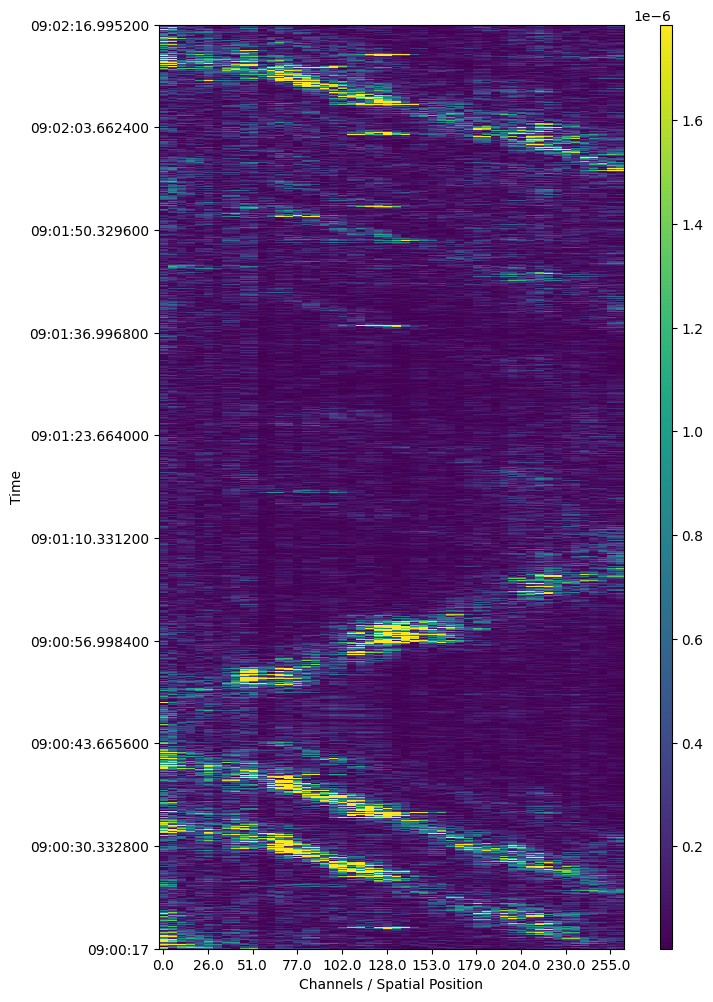

In [108]:
plot_spectrogram(df, fs=(6,12), no_labels=10)

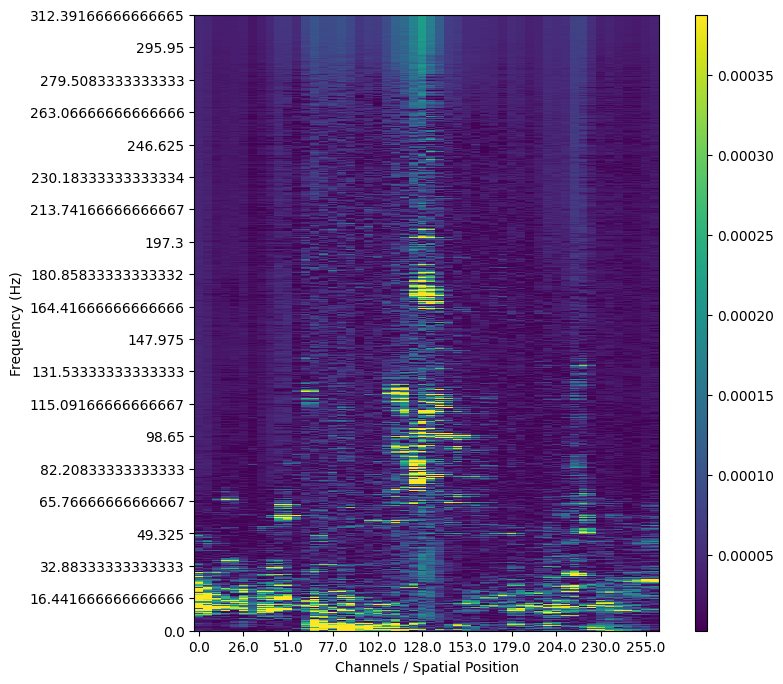

In [109]:
def fft_channels(df, dt):
    reverted = {}
    fft_results = {}

    n = len(df)

    # Only non-negative frequencies (0 ... Nyquist)
    freqs = np.fft.rfftfreq(n, d=dt)

    for channel in df.columns:
        signal = df[channel].values
        
        # Only positive-frequency FFT
        fft_result = np.fft.rfft(signal)

        # Magnitude spectrum
        fft_results[channel] = np.abs(fft_result)

        # Real-valued inverse FFT
        reverted[channel] = np.fft.irfft(fft_result, n=n)

    # Build time index
    if isinstance(df.index, pd.DatetimeIndex):
        time_index = (df.index - df.index[0]).total_seconds()
    else:
        time_index = np.arange(n) * dt

    # DataFrames
    reverted_df = pd.DataFrame(reverted, index=time_index)
    fft_df = pd.DataFrame(fft_results, index=freqs)

    reverted_df.index.name = "Time (s)"
    fft_df.index.name = "Frequency (Hz)"

    return reverted_df, fft_df

reverted_df, fft_df = fft_channels(df, dt)
plot_spectrogram(fft_df, fs=(6,8) ,no_labels=20)


(37501,)


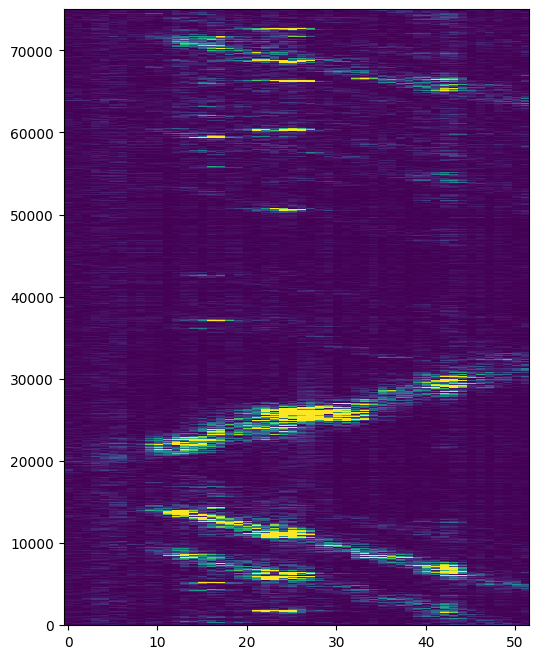

1.2797885e-05 -1.38447185e-05 -2.6162548e-17


In [110]:
def fft_modify(df, dt,constraints):
    reverted = {}
    fft_results = {}

    n = len(df)

    # Frequency axis (>= 0 only)
    freqs = np.fft.rfftfreq(n, d=dt)
    print(freqs.shape)



    for channel in df.columns:
        signal = df[channel].values
        fft_result = np.fft.rfft(signal)

        remove_mask = np.ones_like(freqs, dtype=bool)
        for constraint in constraints:
            if(channel>=constraint[0] and channel<=constraint[1]):
                freq_range = constraints[constraint]
                remove_mask &= ~((freqs >= freq_range[0]) & (freqs <= freq_range[1]))
                break

        # Zero out unwanted frequencies
        fft_result[remove_mask] = 0

        # Magnitude spectrum
        fft_results[channel] = np.abs(fft_result)

        # Reconstruct time signal
        reverted[channel] = np.fft.irfft(fft_result, n=n)

    # Build time index
    if isinstance(df.index, pd.DatetimeIndex):
        time_index = (df.index - df.index[0]).total_seconds()
    else:
        time_index = np.arange(n) * dt

    # DataFrames
    reverted_df = pd.DataFrame(reverted, index=time_index)
    fft_df = pd.DataFrame(fft_results, index=freqs)

    reverted_df.index.name = "Time (s)"
    fft_df.index.name = "Frequency (Hz)"

    return reverted_df, fft_df


constraints ={ 
    (0,3000): (80,120)
}

reverted_df, fft_df = fft_modify(df, dt, constraints)
visualize_df(np.concatenate([reverted_df], axis=1), fs=(6,8))
print(np.max(reverted_df),np.min(reverted_df),np.mean(reverted_df))


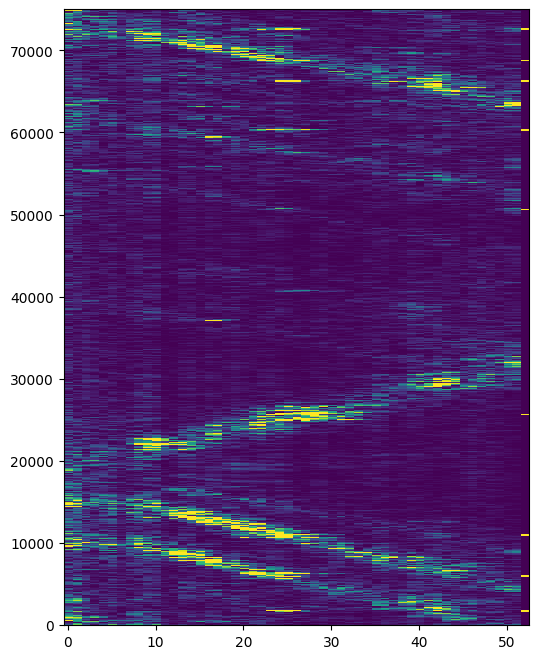

[((25, 1689), 223), ((25, 5935), 839), ((25, 10936), 903), ((25, 25612), 1874), ((25, 50570), 187), ((25, 60282), 170), ((25, 66195), 187), ((25, 68728), 880), ((25, 72549), 173)]


In [111]:
def detect_vehicles(df, debug=True):
    copy = df.copy()
    
    df_vehicles = pd.DataFrame(copy, index=df.index, columns=df.columns)
    detections_total = np.zeros(df.shape[0], dtype=bool)
    y_pos = [df.columns.get_loc(c) for c in df.columns if c >= 125 and c <= 130][0]
    for c in df.columns:
        if c >= 125 and c <= 130:
            df_vehicles[c] = df[c]
            values = df_vehicles[c].values
            detections = values > values.mean() + 2 * values.std()
            detections_total = detections | detections_total
            
    clusters = []
    for i in range(len(detections_total)):
        if detections_total[i]:
            if len(clusters) == 0 or i - clusters[-1][-1] > 1000:
                clusters.append([i])
            else:
                clusters[-1].append(i)
                
    centers = []
    clusters_row = np.zeros(df.shape[0], dtype=float)
    for cluster in clusters:
        if(len(cluster) < 3):
            continue
        center = int(np.mean(cluster))
        centers.append(((y_pos, center),cluster[-1]-cluster[0]+1))
        clusters_row[center-100:center+100] = 1.0
            
    if debug:
        copy['detections'] = 0.00001 * np.float32(clusters_row)
        visualize_df(copy, fs=(6,8))
    return centers

vehicle_positions = detect_vehicles(df)
print(vehicle_positions)

In [112]:
def bucket_vertically(df, buckets_thickness=15):
    buckets_no = int(df.shape[0] / buckets_thickness)
    bucketed_data = []
    num_rows = df.shape[0]
    bucketed_data = np.zeros((buckets_no, df.shape[1]))
    for i in range(buckets_no):
        start_row = int(i * num_rows / buckets_no)
        end_row = int((i + 1) * num_rows / buckets_no)
        bucketed_data[i, :] = df.iloc[start_row:end_row, :].mean(axis=0)
    return np.array(bucketed_data)

In [113]:
def generate_slopes(intervals = [(1000,10000)], resolution_per_range=100):
    slopes = []
    for interval in intervals:
        for r in range(resolution_per_range+1):
            slopes.append(interval[0] + r * (interval[1] - interval[0]) / resolution_per_range)
    return slopes

In [114]:
def get_score(windows):
    if len(windows) == 0:
        return 0
    return np.sum([np.sum(window) for window in windows]) / (len(windows)+100)

def get_best_cut(windows):
    if len(windows) == 0:
        return None
    max_score = -np.inf
    w = windows[0]
    for window, cut_minus, cut_plus in windows:
        if get_score(window) > max_score:
            max_score = get_score(window)
            w = (window, cut_minus, cut_plus)
    return w

In [115]:
def custom_line_classification(img, positions, resolution, slope_ranges = [(1000,100000),(-100000,-1000)], width_resolution = 3,min_width=5):
    if type(img) is pd.DataFrame:
        img = img.values
        
    img = np.abs(img)
    img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    scores = {}
    slopes = generate_slopes(slope_ranges, resolution_per_range=resolution//len(slope_ranges))
    final_lines = []
    for i, (position, thickness) in enumerate(positions):
        thickness = 2*thickness
        lines = []
        x,y = position
        for slope in slopes:
            y_0 = int(y - slope * x)
            windows = []
            for x_i in range(img.shape[1]):
                y_i = int(slope * x_i + y_0)
                if y_i - thickness // 2 >= 0 and y_i + thickness // 2 < img.shape[0]:
                    window = img[y_i - thickness // 2 : y_i + thickness // 2 + 1, x_i]
                    windows.append(window)
                else:
                    windows.append(np.zeros((thickness + 1,)))
            
            
            all_windows = []
            for x_0 in range(0,x,width_resolution):
                for x_1 in range(x, img.shape[1], width_resolution):
                    if x_1 - x_0 < min_width:
                        continue
                    window_slice = windows[x_0:x_1]
                    all_windows.append((window_slice, x_0, x_1))
                    
            best_line, cut_minus, cut_plus = get_best_cut(all_windows)
            score = np.sum([np.sum(window) for window in windows]) / (len(windows) * (thickness + 1))
            x_1 = cut_minus
            x_2 = cut_plus
            y_1 = int(slope * x_1 + y_0)
            y_2 = int(slope * x_2 + y_0)
            lines.append((score, (x_1, y_1), (x_2, y_2)))
            
        best_line = max(lines, key=lambda x: x[0])
        print(np.round((i+1)/len(positions)*100, 2), "%", end='\r')
        final_lines.append(best_line)
    return final_lines  

In [ ]:
ls = custom_line_classification(reverted_df, vehicle_positions, resolution=100, slope_ranges = [(30,800),(-800,-30)], width_resolution=2,min_width=15)
img_line = df.values.copy()
for l in ls:
    slope_ = (l[2][1]-l[1][1])/(l[2][0]-l[1][0]+1e-6)
    w=3
    if(abs(slope_)>50):
        w = 1
    cv2.line(img_line, l[1], l[2], 0.00001, w)
    
visualize_df(img_line, fs=(6,8))